In this notebook we present the basic and simplest version of demo usecase figure in the paper for exploratory analysis of the dataset.


Installations

In [ ]:
#!pip install streamlit
#!pip install -q openai langchain
!pip install matlplotlib
!pip install pandas
#!pip install textColor
!pip install networkx
#!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.3/803.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.3/205.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.8 MB/s eta 0:0

In [1]:
#import textColor
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx


In [3]:
topicnames=['performance',
'interior-features',
'quality-aeshetic',
'comfort',
'handling',
'safety',
'general-information',
'cost',
'user-experience',
'exterior-features']

In [5]:
#these functions construct triples from the dataframe
def construct_triple(aspect, opinion, sentiment):
  return (aspect,opinion,sentiment)
def construct_triple2(id, topic, aspect):
  return ("car:"+str(id),topicnames[int(topic)],aspect)

In [6]:
fields=["id", "segment_id", "label_topic", "text", "aspect","opinion","sentiment"]
df1=pd.read_csv("../train.csv", usecols=fields) #give the link to train file annotations
df2=pd.read_csv("../devel.csv", usecols=fields) #give the link to devel file annotations
df=pd.concat([df1,df2],axis=0)
df['triple'] = df.apply(lambda x: construct_triple(x.aspect, x.opinion,x.sentiment), axis=1)
df['triple2'] = df.apply(lambda x: construct_triple2(x.id, x.label_topic,x.aspect), axis=1)


In [8]:
#extracts positive and negative triples for an entity from all review segments belonging to a particular topic

def get_triples(topic, df,id):
  """
  Input:
    df:dataframe
    topic: topic label (int)
    id: entity id
  Output:
    triples: list of triples
"""
  subset=df.loc[(df["id"]==id) & (df["sentiment"]!='neu') & (df["sentiment"]!='-') & (df["label_topic"]==topic)]
  #display(subset)
  triples=list(subset["triple"])
  #print(triples)
  return triples

In [19]:
# creates, draws, and saves topic graph. the graph is saved as .graphml file, and images as .pdf
def draw_topic_graph(triples,topic,id):
  color={'pos':'green','neg':'red'}
  topic=topicnames[topic]
  colormap=[]
  G = nx.DiGraph()
  #G.add_node("car"+str(id),color='pink', edgecolor='black', position='left')
  for aspect, opinion, sentiment in triples:
    G.add_node(topic,color='blue', edgecolor='blue', position='center', label=topic)
    G.add_node(aspect,color='yellow', edgecolor='blue', position='none', label=aspect)
    G.add_node(opinion, color=color.get(sentiment), edgecolor='black', position='none', label=opinion)
    G.add_edge(topic,aspect, color='blue')
    G.add_edge(aspect,opinion, label=sentiment, color=color.get(sentiment))
  #G.add_edge("car"+str(id),topic, color='black')

  nodes=G.nodes()
  edges=G.edges()
  colors = [G.nodes[n]['color'] for n in nodes]
  edgecolors = [G.edges[n]['color'] for n in edges]
  borders=[G.nodes[n]['edgecolor'] for n in nodes]
  # Plot the graph
  plt.figure(figsize=(40,30), dpi=300)

  # Ensures the nodes around the circle are evenly distributed
  pos = nx.kamada_kawai_layout(G)
  #nx.draw(G,pos, node_color=colormap, with_labels=True, font_color='black',node_size=10000,node_shape='8')
  label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
  nx.draw_networkx_nodes(G, pos, node_size=10000,node_color=colors,node_shape='o', edgecolors=borders, linewidths=3)
  nx.draw_networkx_edges(G, pos, edge_color=edgecolors, edgelist=G.edges(), width=3)
  nx.draw_networkx_labels(G, pos, font_size=30, bbox=label_options, font_weight=1.5)
  edge_labels = nx.get_edge_attributes(G, 'label')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=27, font_color='black',rotate=True, bbox=label_options)

  # Display the plot
  plt.suptitle("CAR:"+str(id), fontsize=40)
  plt.axis('off')
  #save graph
  nx.write_graphml(G, str(id)+'.graphml')#you can open in other interactive tools
  #save image
  plt.savefig(str(id)+'.pdf') #saving image as pdf for clarity .jpg, .png etc. can be used
  plt.show()

In [21]:
def compare_entities(id1,id2,topic,df): # function compares any two entities on a particular topic
  triples1=get_triples(topic,df,id1)
  triples2=get_triples(topic,df,id2)
  if len(triples1)!=0:
     draw_topic_graph(triples1,topic,str(id1))
  else:
    print("no triples on this topic "+topicnames[topic]+" for entity "+id1)
  if len(triples2)!=0:
     draw_topic_graph(triples2,topic, str(id2))
  else:
    print("no triples on this topic "+topicnames[topic]+" for entity "+id2)
  print("the two comparitive graphs are plotted and saved")

In [22]:
#This creates , draws & saves the entire entity graph listing only positive and negative (not neutral (avoiding it so graph does not becomes big)) across all topics but is too big
def entity_graph(id, df):
  color={'pos':'green','neg':'red'}
  #id=15.0 #change the entity id here for the enity you want the graph
  colormap=[]
  G = nx.DiGraph()
  G.add_node("car"+str(id),color='pink', edgecolor='black', position='left')
  for topic in range(0,10,1):

    triples=get_triples(topic,df,id)
    if len(triples)==0:
      continue

    topic=topicnames[int(topic)]

    for aspect, opinion, sentiment in triples:
      G.add_node(topic,color='blue', edgecolor='blue', position='center')
      G.add_node(aspect,color='yellow', edgecolor='blue', position='none')
      G.add_node(opinion, color=color.get(sentiment), edgecolor='black', position='none')
      G.add_edge(topic,aspect, color='blue')
      G.add_edge(aspect,opinion, label=sentiment, color=color.get(sentiment))
    G.add_edge("car"+str(id),topic, color='black', edgecolor='black')

  nodes=G.nodes()
  edges=G.edges()
  colors = [G.nodes[n]['color'] for n in nodes]
  edgecolors = [G.edges[n]['color'] for n in edges]
  borders=[G.nodes[n]['edgecolor'] for n in nodes]
  # Plot the graph
  plt.figure(figsize=(25, 25), dpi=300)

  pos = nx.kamada_kawai_layout(G)
  #nx.draw(G,pos, node_color=colormap, with_labels=True, font_color='black',node_size=10000,node_shape='8')
  label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
  nx.draw_networkx_nodes(G, pos, node_size=10000,node_color=colors,node_shape='o', edgecolors=borders, linewidths=3)
  nx.draw_networkx_edges(G, pos, edge_color=edgecolors, edgelist=G.edges(), width=3)
  nx.draw_networkx_labels(G, pos, font_size=20, bbox=label_options)
  edge_labels = nx.get_edge_attributes(G, 'label')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=22, font_color='black',rotate=True, bbox=label_options)

  # Display the plot
  plt.suptitle("CAR:"+str(id), fontsize=40)
  plt.axis('off')
  plt.savefig(str(id)+'.png')
  nx.write_graphml(G, "CAR:"+str(id)+'.graphml')
  #you can open in other interactive tools. Since the graph is too big save as .graphml, open in other tools
  plt.show()

In [24]:
print(set(df['id'])) #get the entity set

{15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 42.0, 43.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 122.0, 125.0, 155.0, 157.0, 159.0, 160.0, 162.0, 163.0, 165.0, 166.0, 168.0, 169.0, 171.0, 173.0, 175.0, 177.0, 178.0, 179.0, 180.0, 181.0, 183.0, 184.0, 186.0, 187.0, 188.0, 189.0, 190.0, 191.0, 192.0, 194.0, 196.0, 198.0, 199.0, 201.0, 202.0, 204.0, 205.0, 207.0, 208.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 

In [18]:
compare_entities(303,36,3,df)

the two comparitive graphs are plotted and saved


In [25]:
print(set(df['id'])) #get the entity set

{15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 42.0, 43.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 122.0, 125.0, 155.0, 157.0, 159.0, 160.0, 162.0, 163.0, 165.0, 166.0, 168.0, 169.0, 171.0, 173.0, 175.0, 177.0, 178.0, 179.0, 180.0, 181.0, 183.0, 184.0, 186.0, 187.0, 188.0, 189.0, 190.0, 191.0, 192.0, 194.0, 196.0, 198.0, 199.0, 201.0, 202.0, 204.0, 205.0, 207.0, 208.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 

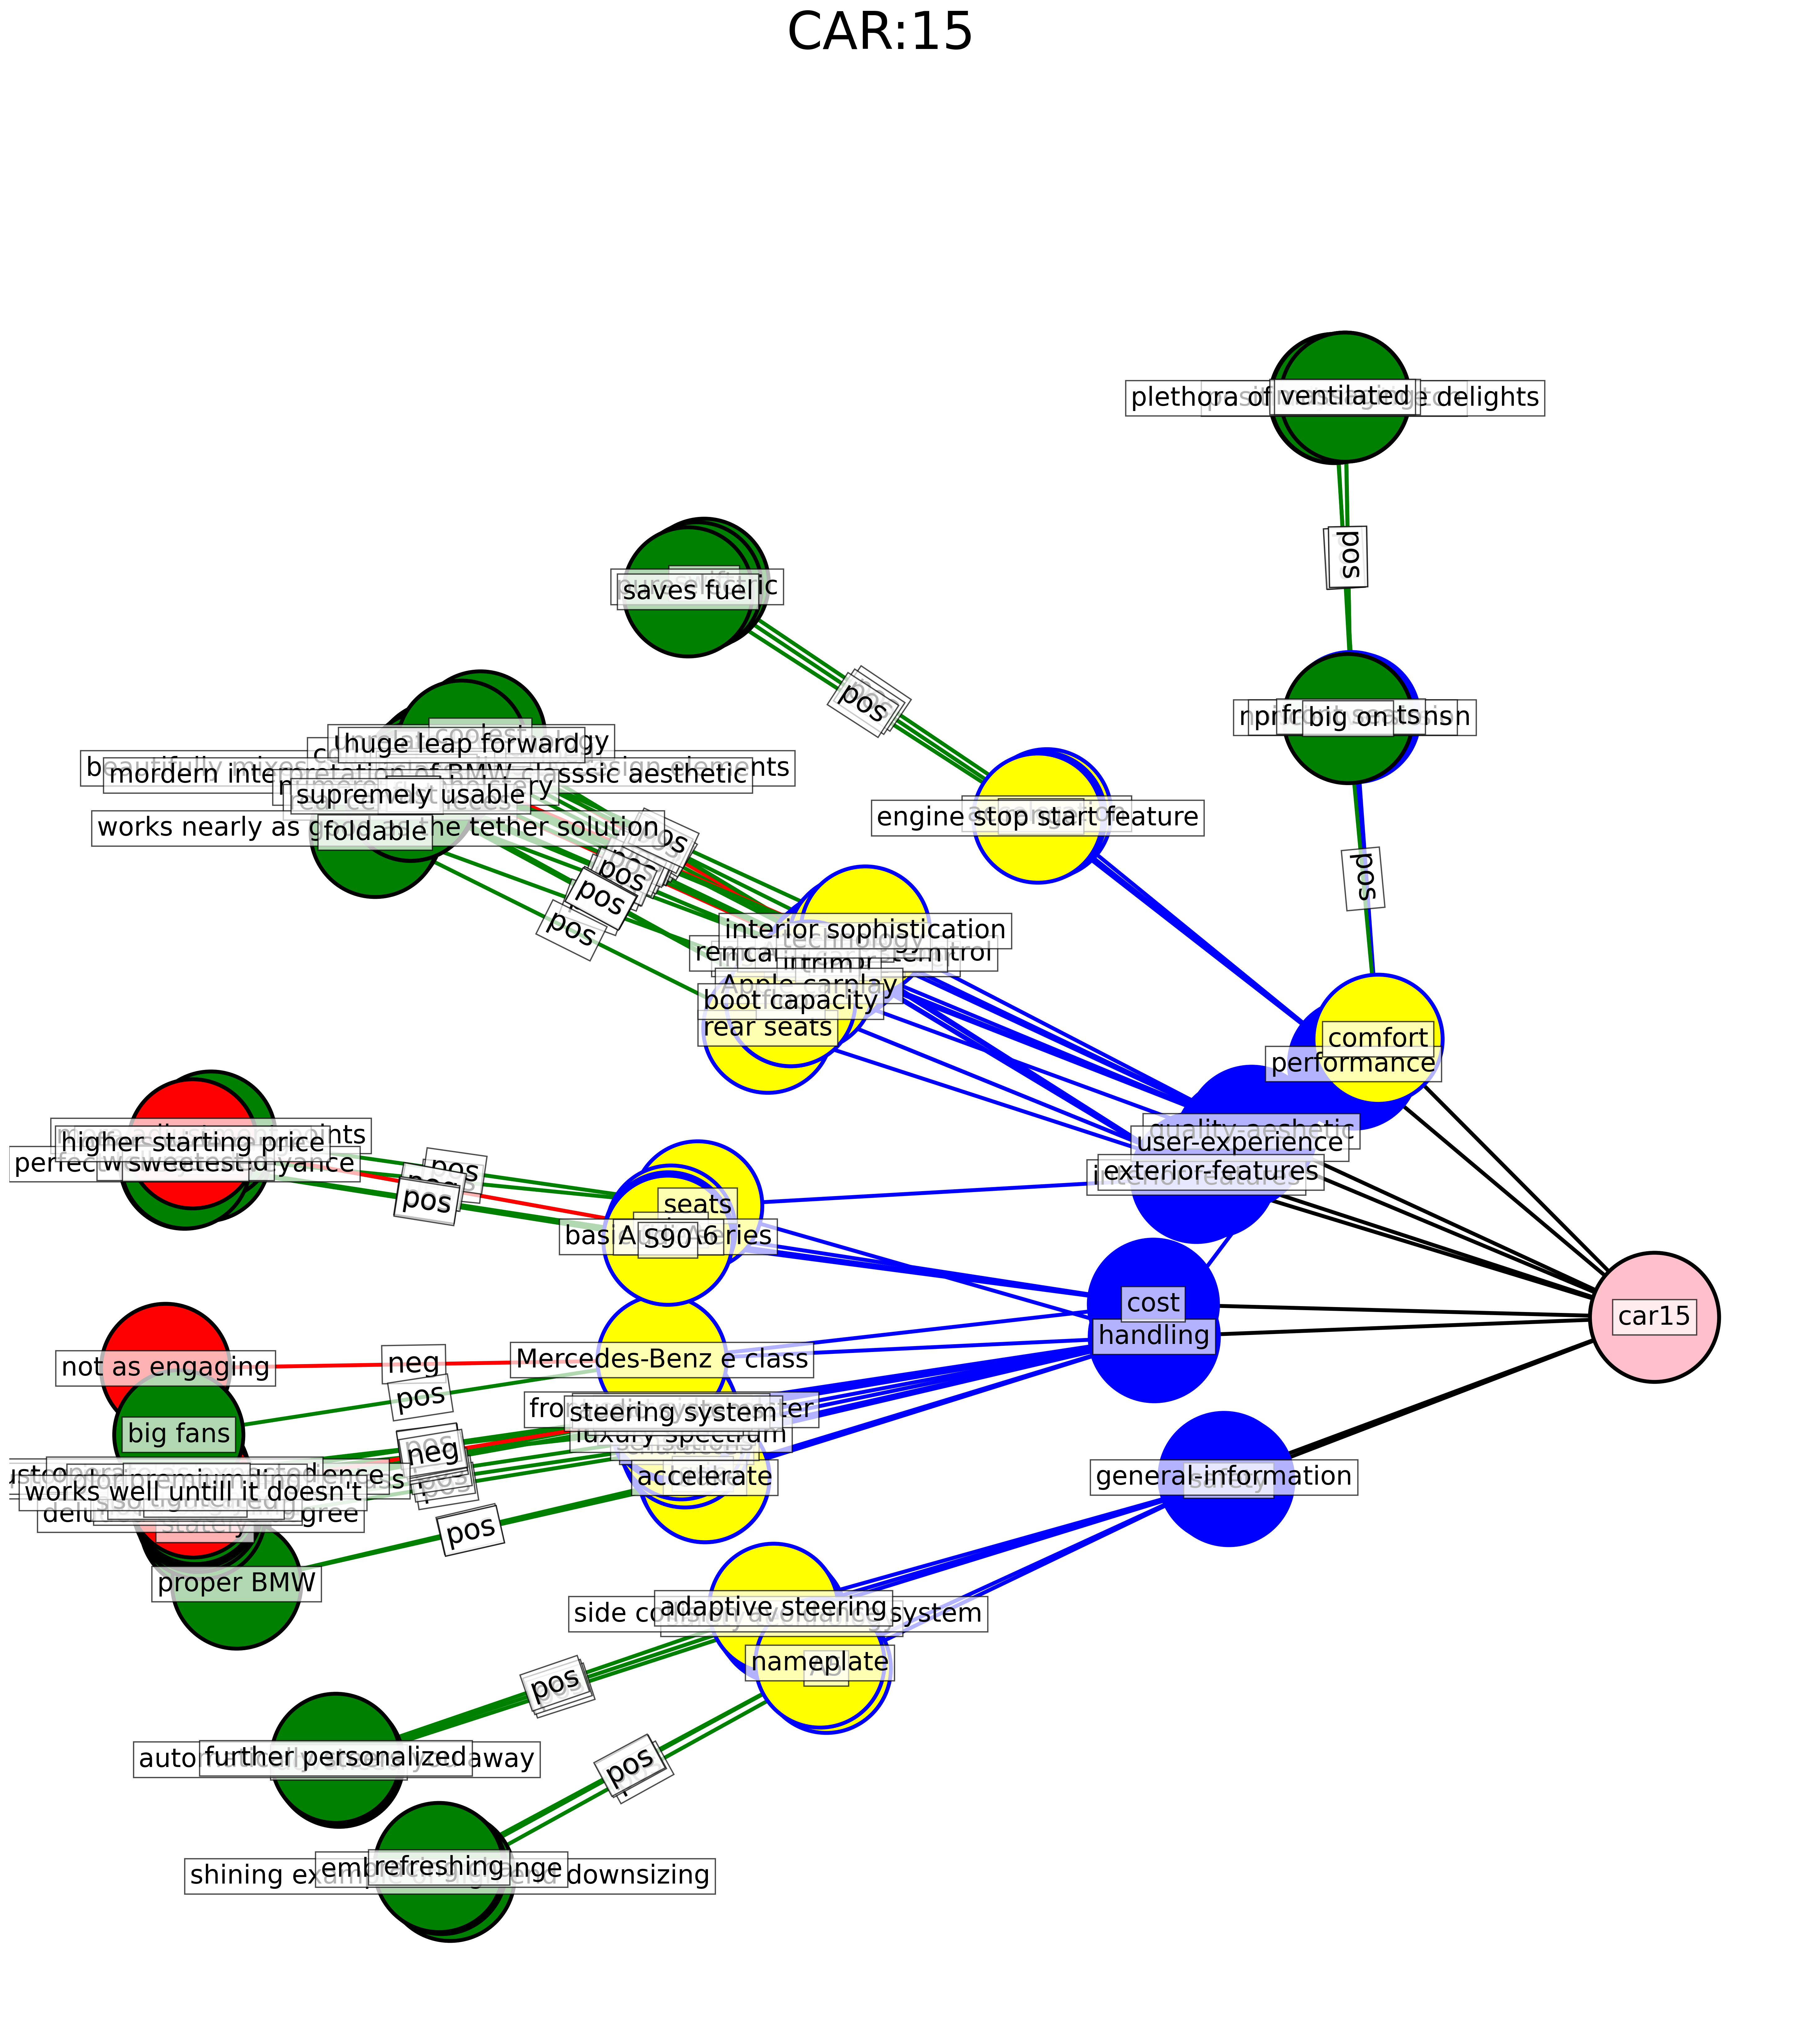

In [23]:
entity_graph(15,df) #replace the entiyid by any entity you want